# Variational Inference: Bayesian Neural Networks

(c) 2016-2018 by Thomas Wiecki, updated by Maxim Kochurov
Comments by Christian Forssén, 2019.

Original blog post: https://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/
and udated version: https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html.

This demonstration relies on the following additional packages:
* `theano`: Theano is a Python library that allows you to define, optimize, and evaluate mathematical expressions involving multi-dimensional arrays efficiently, featuring tight integration with NumPy, transparent use of a GPU, efficient symbolic differentiation, speed and stability optimizations and dynamic C code generation.
* `pymc3`: PyMC3 is a library for probabilistic programming in python. It allows you to write down models using an intuitive syntax to describe a data generating process.
* `arviz`: ArviZ (pronounced "AR-vees") is a Python package for exploratory analysis of Bayesian models. Includes functions for posterior analysis, model checking, comparison and diagnostics.

They can be installed with: `conda install <library>`. 

You might have to specify using the conda-forge channel: `conda install -c conda-forge <library>`.

## Current trends in Machine Learning

In this demonstration, it is shown how to use **Variational Inference** in PyMC3 to fit a simple Bayesian Neural Network. The authors will also discuss how bridging Probabilistic Programming and Deep Learning can open up very interesting avenues to explore in future research.

### Probabilistic Programming at scale
**Probabilistic Programming** allows very flexible creation of custom probabilistic models and is mainly concerned with **insight** and learning from your data. The approach is inherently **Bayesian** so we can specify **priors** to inform and constrain our models and get uncertainty estimation in form of a **posterior** distribution. Using [MCMC sampling algorithms](https://twiecki.github.io/blog/2015/11/10/mcmc-sampling/) we can draw samples from this posterior to very flexibly estimate these models. PyMC3 and [Stan](http://mc-stan.org/) are the current state-of-the-art tools to consruct and estimate these models. One major drawback of sampling, however, is that it's often very slow, especially for high-dimensional models. That's why more recently, **variational inference** algorithms have been developed that are almost as flexible as MCMC but much faster. Instead of drawing samples from the posterior, these algorithms instead fit a distribution (e.g. normal) to the posterior turning a sampling problem into and optimization problem. [ADVI](http://arxiv.org/abs/1506.03431) -- Automatic Differentation Variational Inference -- is implemented in PyMC3 and [Stan](http://mc-stan.org/), as well as a new package called [Edward](https://github.com/blei-lab/edward/) which is mainly concerned with Variational Inference. 

Unfortunately, when it comes to traditional ML problems like classification or (non-linear) regression, Probabilistic Programming often plays second fiddle (in terms of accuracy and scalability) to more algorithmic approaches like [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) (e.g. [random forests](https://en.wikipedia.org/wiki/Random_forest) or [gradient boosted regression trees](https://en.wikipedia.org/wiki/Boosting_(machine_learning)).

### Deep Learning

Now in its third renaissance, deep learning has been making headlines repeatadly by dominating almost any object recognition benchmark, [kicking ass at Atari games](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf), and [beating the world-champion Lee Sedol at Go](http://www.nature.com/nature/journal/v529/n7587/full/nature16961.html). From a statistical point, Neural Networks are extremely good non-linear function approximators and representation learners. While mostly known for classification, they have been extended to unsupervised learning with [AutoEncoders](https://arxiv.org/abs/1312.6114) and in all sorts of other interesting ways (e.g. [Recurrent Networks](https://en.wikipedia.org/wiki/Recurrent_neural_network), or [MDNs](http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html) to estimate multimodal distributions). Why do they work so well? No one really knows as the statistical properties are still not fully understood.

A large part of the innoviation in deep learning is the ability to train these extremely complex models. This rests on several pillars:
* Speed: facilitating the GPU allowed for much faster processing.
* Software: frameworks like [Theano](http://deeplearning.net/software/theano/) and [TensorFlow](https://www.tensorflow.org/) allow flexible creation of abstract models that can then be optimized and compiled to CPU or GPU.
* Learning algorithms: training on sub-sets of the data -- stochastic gradient descent -- allows us to train these models on massive amounts of data. Techniques like drop-out avoid overfitting.
* Architectural: A lot of innovation comes from changing the input layers, like for convolutional neural nets, or the output layers, like for [MDNs](http://cbonnett.github.io/MDN_EDWARD_KERAS_TF.html).

### Bridging Deep Learning and Probabilistic Programming
On one hand we have Probabilistic Programming which allows us to build rather small and focused models in a very principled and well-understood way to gain insight into our data; on the other hand we have deep learning which uses many heuristics to train huge and highly complex models that are amazing at prediction. Recent innovations in variational inference allow probabilistic programming to scale model complexity as well as data size. We are thus at the cusp of being able to combine these two approaches to hopefully unlock new innovations in Machine Learning. For more motivation, see also [Dustin Tran's](https://twitter.com/dustinvtran) recent [blog post](http://dustintran.com/blog/a-quick-update-edward-and-some-motivations/).

While this would allow Probabilistic Programming to be applied to a much wider set of interesting problems, I believe this bridging also holds great promise for innovations in Deep Learning. Some ideas are:
* **Uncertainty in predictions**: As we will see below, the Bayesian Neural Network informs us about the uncertainty in its predictions. I think uncertainty is an underappreciated concept in Machine Learning as it's clearly important for real-world applications. But it could also be useful in training. For example, we could train the model specifically on samples it is most uncertain about.
* **Uncertainty in representations**: We also get uncertainty estimates of our weights which could inform us about the stability of the learned representations of the network.
* **Regularization with priors**: Weights are often L2-regularized to avoid overfitting, this very naturally becomes a Gaussian prior for the weight coefficients. We could, however, imagine all kinds of other priors, like spike-and-slab to enforce sparsity (this would be more like using the L1-norm).
* **Transfer learning with informed priors**: If we wanted to train a network on a new object recognition data set, we could bootstrap the learning by placing informed priors centered around weights retrieved from other pre-trained networks, like [GoogLeNet](https://arxiv.org/abs/1409.4842). 
* **Hierarchical Neural Networks**: A very powerful approach in Probabilistic Programming is hierarchical modeling that allows pooling of things that were learned on sub-groups to the overall population (see my tutorial on [Hierarchical Linear Regression in PyMC3](https://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/)). Applied to Neural Networks, in hierarchical data sets, we could train individual neural nets to specialize on sub-groups while still being informed about representations of the overall population. For example, imagine a network trained to classify car models from pictures of cars. We could train a hierarchical neural network where a sub-neural network is trained to tell apart models from only a single manufacturer. The intuition being that all cars from a certain manufactures share certain similarities so it would make sense to train individual networks that specialize on brands. However, due to the individual networks being connected at a higher layer, they would still share information with the other specialized sub-networks about features that are useful to all brands. Interestingly, different layers of the network could be informed by various levels of the hierarchy -- e.g. early layers that extract visual lines could be identical in all sub-networks while the higher-order representations would be different. The hierarchical model would learn all that from the data.
* **Other hybrid architectures**: We can more freely build all kinds of neural networks. For example, Bayesian non-parametrics could be used to flexibly adjust the size and shape of the hidden layers to optimally scale the network architecture to the problem at hand during training. Currently, this requires costly hyper-parameter optimization and a lot of tribal knowledge.

## Bayesian Neural Networks in PyMC3

### Generating data

First, lets generate some toy data -- a simple binary classification problem that's not linearly separable.

In [1]:
%matplotlib inline
import sklearn
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

import seaborn as sns
sns.set()
sns.set_context("talk")

#sns.set_style('presentation')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

#### Import theano and pymc3

In [2]:
# suppress some theano compilation errors with MacOSX clang compiler
import theano
# CF added (https://stackoverflow.com/questions/51238578/error-non-constant-expression-cannot-be-narrowed-from-type-npy-intp-to-int)
theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T

In [4]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

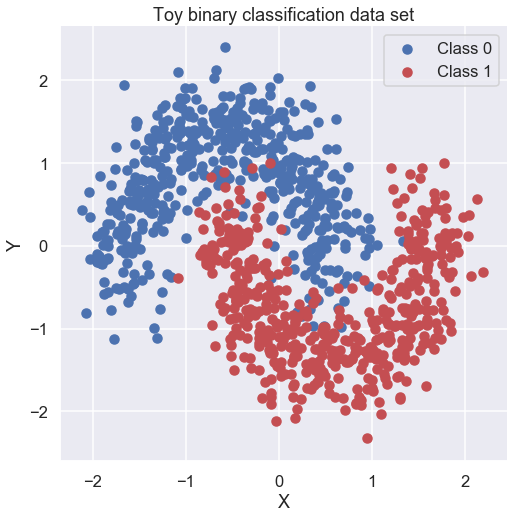

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

### Model specification

A neural network is quite simple. The basic unit is a [perceptron](https://en.wikipedia.org/wiki/Perceptron) which is nothing more than [logistic regression](http://pymc-devs.github.io/pymc3/notebooks/posterior_predictive.html#Prediction). We use many of these in parallel and then stack them up to get hidden layers. Here we will use 2 hidden layers with 5 neurons each which is sufficient for such a simple problem.

In [6]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', X_train)
        ann_output = pm.Data('ann_output', Y_train)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(X.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(X_train, Y_train)

That's not so bad. The `Normal` priors help regularize the weights. Usually we would add a constant `b` to the inputs but I omitted it here to keep the code cleaner.

### Variational Inference: Scaling model complexity

We could now just run a MCMC sampler like NUTS which works pretty well in this case, but as I already mentioned, this will become very slow as we scale our model up to deeper architectures with more layers.

Instead, we will use [ADVI](https://arxiv.org/abs/1603.00788) variational inference algorithm which was recently added to `PyMC3`, and updated to use the operator variational inference (OPVI) framework. This is much faster and will scale better.

**Note**, however, that this is a mean-field approximation so we **ignore correlations** in the posterior.

In [7]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [8]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)

Average Loss = 170.95: 100%|██████████| 30000/30000 [00:29<00:00, 1012.43it/s]
Finished [100%]: Average Loss = 171.03


CPU times: user 27 s, sys: 2.86 s, total: 29.9 s
Wall time: 2min 1s


Performance wise that's pretty good considering that NUTS is having a really hard time. Further below we make this even faster. To make it really fly, we probably want to run the Neural Network on the GPU.

As samples are more convenient to work with, we can very quickly draw samples from the variational approximation using the `sample` method (this is just sampling from Normal distributions, so not at all the same like MCMC):

Plotting the objective function (ELBO) we can see that the optimization slowly improves the fit over time.

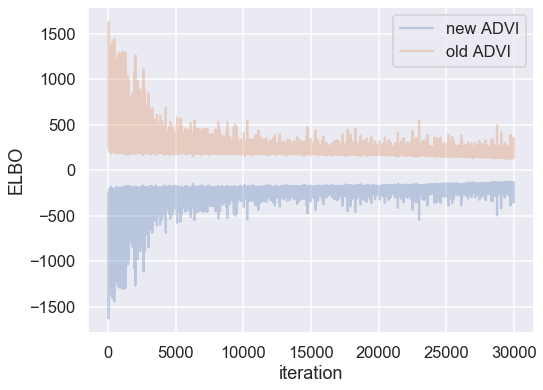

In [9]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(-inference.hist, label='new ADVI', alpha=.3)
ax.legend()
ax.set_ylabel('ELBO')
ax.set_xlabel('iteration');

In [10]:
trace = approx.sample(draws=5000)

Now that we trained our model, lets predict on the hold-out set using a posterior predictive check (PPC). 
1. We can use `sample_posterior_predictive() <../api/inference.rst>`__ to generate new data (in this case class predictions) from the posterior (sampled from the variational estimation).
1. It is better to get the node directly and build theano graph using our approximation (approx.sample_node) , we get a lot of speed up

In [11]:
# We can get predicted probability from model
neural_network.out.distribution.p

sigmoid.0

In [12]:
# create symbolic input
x = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x.tag.test_value = np.empty_like(X_train[:10])
n.tag.test_value = 100
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n,
                                   more_replacements={neural_network['ann_input']: x})
# It is time to compile the function
# No updates are needed for Approximation random generator
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x, n], _sample_proba)

# Create bechmark functions
def production_step1():
    pm.set_data(new_data={'ann_input': X_test, 'ann_output': Y_test}, model=neural_network)
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False, model=neural_network)

    # Use probability of > 0.5 to assume prediction of class 1
    pred = ppc['out'].mean(axis=0) > 0.5

def production_step2():
    sample_proba(X_test, 500).mean(0) > 0.5

See the difference

In [13]:
%timeit production_step1()

3.14 s ± 75.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit production_step2()

29.1 ms ± 277 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Let’s go ahead and generate predictions:

In [15]:
pred = sample_proba(X_test, 500).mean(0) > 0.5

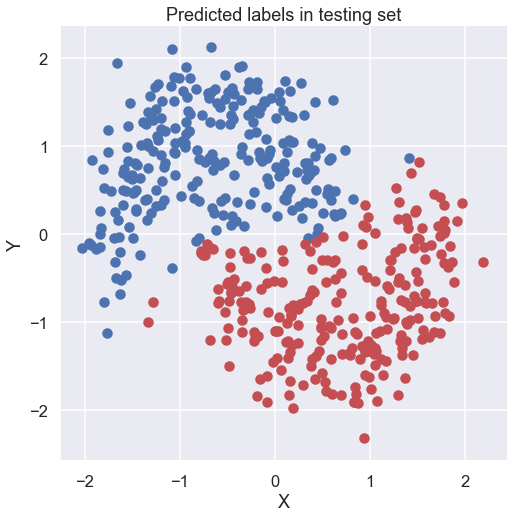

In [16]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [17]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 90.0%


Hey, our neural network did all right!

## Lets look at what the classifier has learned

For this, we evaluate the class probability predictions on a grid over the whole input space.

In [18]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [19]:
ppc = sample_proba(grid_2d ,500)

### Probability surface

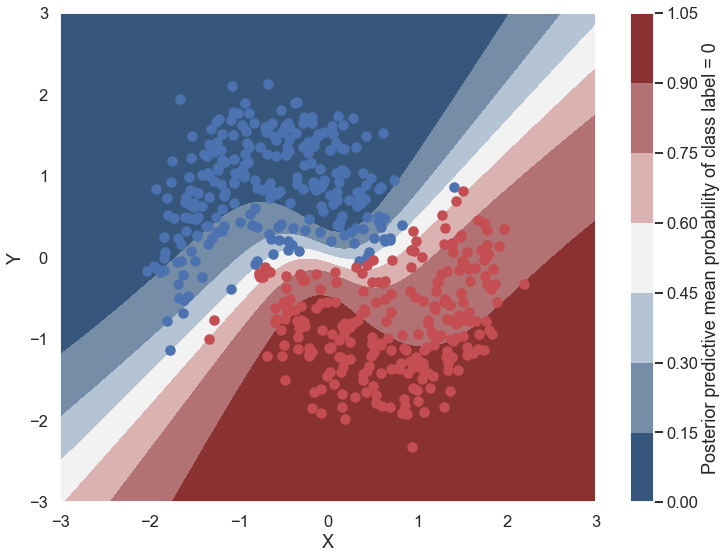

In [20]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

### Uncertainty in predicted value

So far, everything I showed we could have done with a non-Bayesian Neural Network. The mean of the posterior predictive for each class-label should be identical to maximum likelihood predicted values. However, we can also look at the standard deviation of the posterior predictive to get a sense for the uncertainty in our predictions. Here is what that looks like:

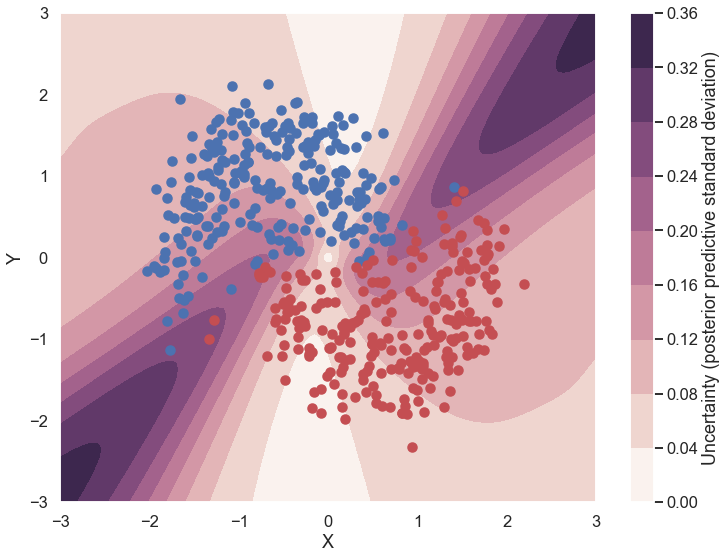

In [21]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

We can see that very close to the decision boundary, our uncertainty as to which label to predict is highest. You can imagine that associating predictions with uncertainty is a critical property for many applications like health care. To further maximize accuracy, we might want to train the model primarily on samples from that high-uncertainty region.

It is also clear that the uncertainty is large in the region where there is no training data. That is what should be expected, and it is good that our network shows this explicitly. The normal neural network would not give any such signals.

## Mini-batch ADVI

So far, we have trained our model on all data at once. Obviously this won't scale to something like ImageNet. Moreover, training on mini-batches of data (stochastic gradient descent) avoids local minima and can lead to faster convergence.

Fortunately, ADVI can be run on mini-batches as well. It just requires some setting up:

In [22]:
minibatch_x = pm.Minibatch(X_train, batch_size=50)
minibatch_y = pm.Minibatch(Y_train, batch_size=50)
neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    approx = pm.fit(40000, method=pm.ADVI())

Average Loss = 121.28: 100%|██████████| 40000/40000 [00:18<00:00, 2117.55it/s]
Finished [100%]: Average Loss = 121.26


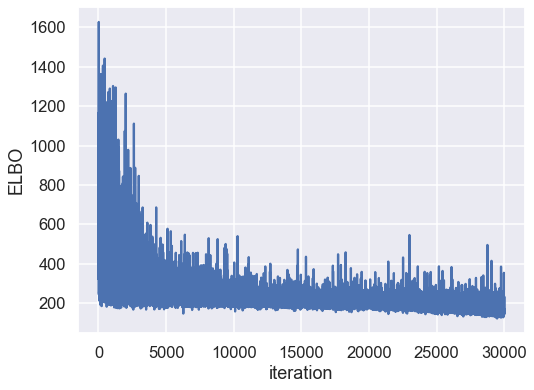

In [23]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(inference.hist)
ax.set_ylabel('ELBO')
ax.set_xlabel('iteration');

As you can see, mini-batch ADVI's running time is much lower. It also seems to converge faster.

For fun, we can also look at the trace. The point is that we also get uncertainty of our Neural Network weights.

The plotting of traces in pyMC3 requires the ArviZ module.

In [24]:
pm.traceplot(trace);

ImportError: ArviZ is not installed. In order to use `plot_trace`:
pip install arviz


## Next steps

[`Theano`](http://deeplearning.net/software/theano/), which is used by `PyMC3` as its computational backend, was mainly developed for estimating neural networks and there are great libraries like [`Lasagne`](https://github.com/Lasagne/Lasagne) that build on top of `Theano` to make construction of the most common neural network architectures easy. There is a [follow-up blog post on how to use Lasagne together with PyMC3](https://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/).

You should be able to run this example on the GPU by setting `device = gpu` and `floatX = float32` in your `.theanorc`.

You might argue that the above network isn't really deep, but note that we could easily extend it to have more layers, including convolutional ones to train on more challenging data sets, as demonstrated [here]([follow-up blog post on how to use Lasagne together with PyMC3](https://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/).

## Acknowledgements

This notebook is very much inspired by a blog post written by Thomas Wiecki (and updated by Maxim Kochurov). The
original posts are available [here](http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/) and [here](https://docs.pymc.io/notebooks/bayesian_neural_network_advi.html).

This example uses the [PyMC3](https://docs.pymc.io/) package for probabilistic programming, and relies in particular on the [ADVI](http://pymc-devs.github.io/pymc3/api.html#advi) implementation by [Taku Yoshioka](https://github.com/taku-y).